In [10]:
import numpy as np
import torch
from torch import nn
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [11]:
data= np.load('Datos/Transformados/montecarlo_data.npz')
features = data['features']
target = data['target']

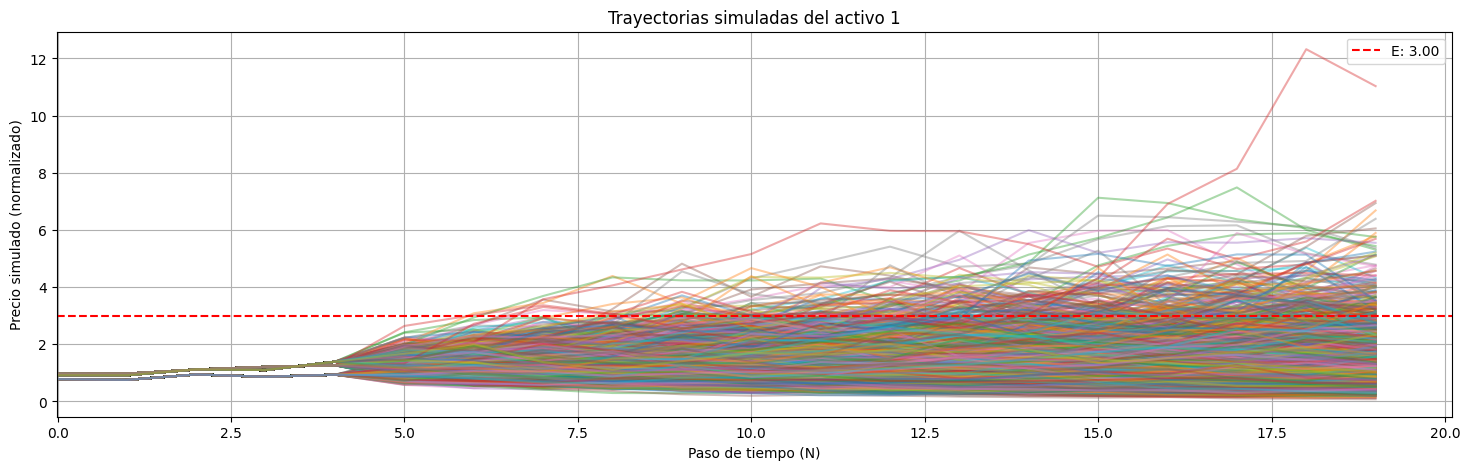

In [12]:
plt.figure(figsize=(18, 5))
for i in range(1000):  # plotea 20 trayectorias aleatorias del activo 1
    plt.plot(features[i, :], alpha=0.4)
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas del activo 1")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

In [13]:
features[:, :5, :]

array([[[0.96477263, 0.91678966, 0.77928616],
        [0.97192162, 0.91520923, 0.75219977],
        [1.114486  , 1.12007406, 0.94245728],
        [1.20875888, 1.09777014, 0.86145522],
        [1.26407731, 1.3898672 , 0.93349761]],

       [[0.96477263, 0.91678966, 0.77928616],
        [0.97192162, 0.91520923, 0.75219977],
        [1.114486  , 1.12007406, 0.94245728],
        [1.20875888, 1.09777014, 0.86145522],
        [1.26407731, 1.3898672 , 0.93349761]],

       [[0.96477263, 0.91678966, 0.77928616],
        [0.97192162, 0.91520923, 0.75219977],
        [1.114486  , 1.12007406, 0.94245728],
        [1.20875888, 1.09777014, 0.86145522],
        [1.26407731, 1.3898672 , 0.93349761]],

       ...,

       [[0.96477263, 0.91678966, 0.77928616],
        [0.97192162, 0.91520923, 0.75219977],
        [1.114486  , 1.12007406, 0.94245728],
        [1.20875888, 1.09777014, 0.86145522],
        [1.26407731, 1.3898672 , 0.93349761]],

       [[0.96477263, 0.91678966, 0.77928616],
        [0.97

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=42,
    shuffle=True 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42,
    shuffle=True  
)

print(f"Features de Train:  {X_train.shape}")   
print(f"Targets de Train:   {y_train.shape}")
print(f"Features de validation:  {X_val.shape}") 
print(f"Targets de validation:   {y_val.shape}")
print(f"Features de test:  {X_test.shape}") 
print(f"Targets de test:   {y_test.shape}")




Features de Train:  (60000, 20, 3)
Targets de Train:   (60000,)
Features de validation:  (20000, 20, 3)
Targets de validation:   (20000,)
Features de test:  (20000, 20, 3)
Targets de test:   (20000,)


In [15]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))


batch_size = 64 
train_dataloader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True) 


val_dataloader = DataLoader(dataset=val_dataset, 
                          batch_size=batch_size, 
                          shuffle=False) 

test_dataloader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False) 

In [16]:
import torch
import torch.nn as nn

class LSTMmodel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, dropout=0.3):
        super(LSTMmodel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()              

    def forward(self, x):
        """
        x: tensor de forma (batch_size, pasos_temporales, input_dim)
        """
        out, _ = self.lstm(x)           
        out = out[:, -1, :]             
        out = self.fc(out)              
        out = self.relu(out)  
        return out


In [17]:
class EarlyStopper: 
    def __init__(self, patience=1, min_delta=0,save_path = "./best_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss,model):
        """Returns whether the training should stop or not. If stopping criterion is not met returns False."""
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
def plot_history(history:dict, plot_list=[], scale="linear"):
    fig = plt.figure(figsize=(14, 7))
    plt.xlabel("Epoch")
    for plot in plot_list:
        plt.plot(history["epoch"][2:], history[plot][2:], label=plot)
    plt.yscale(scale)
    plt.legend(fontsize=30)
    plt.show()

In [19]:
def train_model(model, 
                train_dataloader=None,
                val_dataloader=None,
                test_dataloader=None,
                criterion=None, 
                optimizer=None,        
                gamma=None,       
                epochs=None,
                lr=None,
                early_stopper=None,
                clip_value=None,
                dropout = None, 
                hidden_size = None,
                num_layers = None):
    
    history = {"loss": [], "val_loss": [],"epoch":[]}
    optimizer = optimizer(model.parameters(), lr = lr)


    if gamma is not None:
        lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for data in train_dataloader:
            inputs, targets = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()

            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        lr_scheduler.step()
        avg_loss = running_loss / len(train_dataloader.dataset)
        history['loss'].append(avg_loss)

        model.eval()
        running_vloss = 0.0

        with torch.no_grad():
            for vdata in val_dataloader:
                vinputs, vtargets = vdata

                voutputs = model(vinputs)
                vloss = criterion(voutputs.squeeze(), vtargets)

                running_vloss += vloss.item() * vinputs.size(0)
        
        avg_vloss = running_vloss/len(val_dataloader.dataset)
        history['val_loss'].append(avg_vloss)
        history['epoch'].append(epoch + 1)

        if early_stopper is not None:
            if early_stopper.early_stop(avg_loss, model):
                print(f'Early stop en epoch {epoch+1}')
                break
        
        print(f'Epoch {epoch + 1} | Train Loss: {avg_loss} | Validation Loss: {avg_vloss}')
    
    model = LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
    model.load_state_dict(torch.load("best_model.pt"))

    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for tdata in test_dataloader:
            tinputs, ttargets = tdata

            toutputs = model(tinputs)
            
            tloss = criterion(toutputs.squeeze(), ttargets) 

            running_test_loss += tloss.item() * tinputs.size(0)
            
    avg_test_loss = running_test_loss / len(test_dataloader.dataset)
    history['test_loss'] = avg_test_loss
    print(tloss)
    return history

In [20]:
dropout = 0.2
num_layers = 2
hidden_size = 32
model = LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
early_stopper = EarlyStopper(patience=5, min_delta=0)


In [25]:
history = train_model(model, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=nn.MSELoss(), 
            lr=0.0001,
            optimizer = optim.Adam, 
            epochs=50,
            early_stopper=early_stopper, 
            clip_value=1,
            gamma= 0.95,
            dropout= dropout,
            hidden_size=hidden_size,
            num_layers= num_layers
            )

Epoch 1 | Train Loss: 0.005587468669905017 | Validation Loss: 0.0005233451439533382
Epoch 2 | Train Loss: 0.0005787327793892472 | Validation Loss: 0.0002615079019917175
Epoch 3 | Train Loss: 0.0003910928547848016 | Validation Loss: 0.00022077745427377522
Epoch 4 | Train Loss: 0.00030790977482683955 | Validation Loss: 0.0001472397199482657
Epoch 5 | Train Loss: 0.0002562016738268236 | Validation Loss: 0.00013469473763834684
Epoch 6 | Train Loss: 0.00022305366804357618 | Validation Loss: 0.00010383856783155352
Epoch 7 | Train Loss: 0.00019094982090561341 | Validation Loss: 9.788901183055713e-05
Epoch 8 | Train Loss: 0.00017003129766477893 | Validation Loss: 7.685830032569357e-05
Epoch 9 | Train Loss: 0.00015041089154935132 | Validation Loss: 6.225889106281102e-05
Epoch 10 | Train Loss: 0.00013816070178290828 | Validation Loss: 6.129843985545449e-05
Epoch 11 | Train Loss: 0.00012647918640480688 | Validation Loss: 5.170071119791828e-05
Epoch 12 | Train Loss: 0.00011676595315996868 | Valida

In [21]:
model = LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
with torch.no_grad():
            X_test_t = torch.tensor(X_test, dtype=torch.float)
            Y_test_t = torch.tensor(Y_test, dtype=torch.float)
            t_preds = model(X_test_t)
            
            MAE = mean_absolute_error(toutputs.squeeze(), ttargets)
            MSE = mean_squared_error(toutputs.squeeze(), ttargets)
            print(MAE)

            

0.003750106319785118
0.004039955325424671
0.004422153811901808
0.004246577620506287
0.0035843090154230595
0.005343558266758919
0.0042190211825072765
0.004184390418231487
0.00518263503909111
0.0038787275552749634
0.004035751335322857
0.0035798102617263794
0.004043689928948879
0.003989540971815586
0.00370300211943686
0.0035344623029232025
0.0037171482108533382
0.006165356375277042
0.004910017363727093
0.004595054313540459
0.004750322550535202
0.004998180083930492
0.004810441751033068
0.003240554127842188
0.005032410845160484
0.0037171323783695698
0.0039223311468958855
0.003036320675164461
0.004764856770634651
0.00516956951469183
0.0038066632114350796
0.005215240642428398
0.005017261952161789
0.005699248518794775
0.002722710371017456
0.004179966636002064
0.004477172624319792
0.004046075977385044
0.004093414172530174
0.004684284795075655
0.004136001691222191
0.004735111258924007
0.0028701270930469036
0.0036158564034849405
0.003810127032920718
0.003583940677344799
0.0043684374541044235
0.00

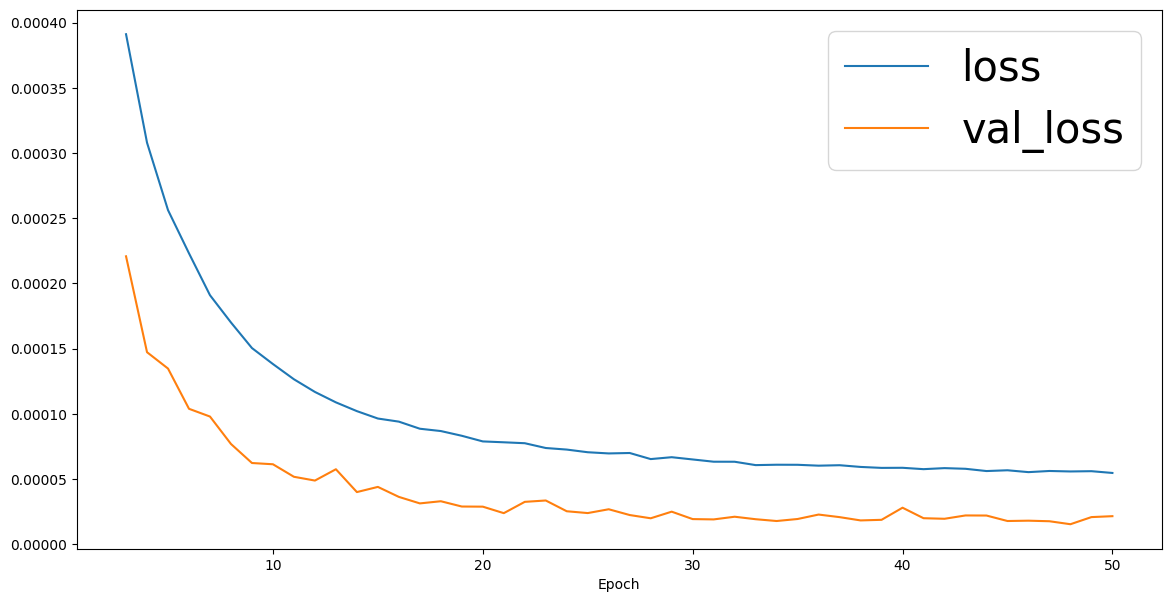

In [26]:
plot_history(history, ['loss', 'val_loss'])

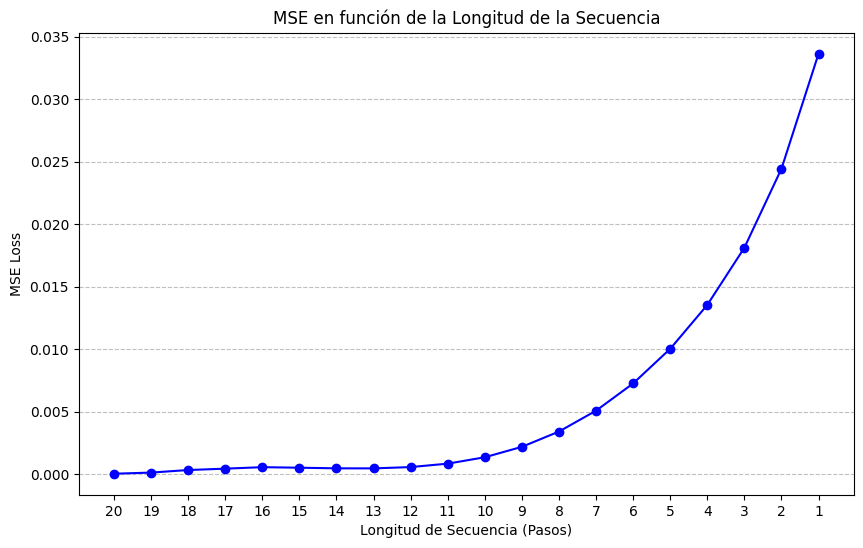

In [37]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

# --- Asumiendo que X_test, y_test, model están definidos ---
# X_test, y_test son probablemente arrays de NumPy

MAE_pasos = []
criterion = nn.MSELoss()
max_lookback = X_test.shape[1] 

# --- Es más eficiente convertir y_test UNA SOLA VEZ, fuera del bucle ---
# Asumo que y_test es un array de NumPy
y_test_tensor = torch.tensor(y_test, dtype=torch.float).squeeze()
# Si y_test ya era un tensor, simplemente usa:
# y_test_tensor = y_test.squeeze()

for i in range(max_lookback, 0, -1):
    # Esto sigue siendo NumPy, lo cual está bien
    datos = X_test[:, -i:, :]
    
    model.eval()
    with torch.no_grad():
        # 1. Convertir los datos de entrada a tensor
        datos_torch = torch.tensor(datos, dtype=torch.float)
        
        # 2. Obtener la predicción (sigue siendo un tensor)
        pred_tensor = model(datos_torch)
        pred_tensor = pred_tensor.squeeze() 
        
        # ¡¡NO CONVERTIR A NUMPY AQUÍ!!
        # Línea eliminada: pred = pred.squeeze().cpu().numpy()  
        
    # 3. Calcular el loss (ambos son tensores de PyTorch)
    #    Orden semántico correcto: (predicción, objetivo)
    mae_loss = criterion(pred_tensor, y_test_tensor)
    
    # 4. Añadir el valor numérico (un float de Python) a la lista
    MAE_pasos.append(mae_loss.item())

# --- Tu código para graficar (es correcto) ---
pasos = list(range(max_lookback, 0, -1))

plt.figure(figsize=(10, 6))
plt.plot(pasos, MAE_pasos, marker='o', linestyle='-', color='b')
plt.xlabel("Longitud de Secuencia (Pasos)")
# Nota: Estás usando nn.MSELoss, así que la métrica es MSE, no MAE
plt.ylabel("MSE Loss") 
plt.title("MSE en función de la Longitud de la Secuencia")
plt.gca().invert_xaxis()
plt.xticks(range(max_lookback, 0, -1))
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)
plt.show()

In [ ]:
history = train_model(model, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=nn.MSELoss(), 
            lr=0.0001,
            optimizer = optim.Adam, 
            epochs=50,
            early_stopper=early_stopper, 
            clip_value=1,
            gamma= 0.95,
            dropout= dropout,
            hidden_size=hidden_size,
            num_layers= num_layers
            )